# Using Linear Regression for Classification with One-Hot Encoding

In [1]:
# Standard imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Required for modeling and evaluation
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, mean_squared_error, classification_report

### 1. Dataset Selection and Preparation

The dataset is originated from a U.S. bank and the model goal will be to predict if a particular customer will leave the bank or not.

- **Total Observations**: 10,000 (79.6% of the customers don't leave the bank and 20.4% will leave)
- **Features**:
  1. `CreditScore`: It ranges from 350 (poor) to 850 (excellent).
  2. `Geography`: 3 countries ('France' 'Spain' 'Germany'), we will perform One-Hot Encoding.
  3. `Gender`: Female or Male, we will encode with a binary label.
  4. `Age`: Age of the customer.
  5. `Tenure`: Number of years being a customer of the bank.
  6. `Balance`: Amount of euros in the bank.
  7. `NumOfProducts`: Number of products contracted with the bank.
  8. `HasCrCard`: Credit card indicator. Has a card = 1.
  9. `IsActiveMember`: Active member indicator. Is Active = 1
  10. `EstimatedSalary`: Estimated salary in euros.   
.
- **Label**:

    Each sample in the dataset is labelled with the Exited status of the customer in binary.

    `Not Exited` = 0   
    `Exited` = 1

In [2]:
loan_data = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')

In [3]:
#Exploratory Data Analysis
loan_data.head()
#loan_data.describe()
#loan_data['Exited'].value_counts(normalize=True)
#sns.pairplot(loan_data, diag_kind='hist')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### 2. Dataset Preprocessing
- **Drop columns** not relevant for the analysis (`RowNumber`, `CustomerId`, `Surname`)
- **Missing values**: There are no missing values.
- **Duplicates**: There are no duplicates.
- **Outliers**: Therea are not relevant outliers.
- **One-Hot encoding**: Performed for `Geography`.
- **Binary encoding**: For feature `Gender`.

**Training, Validation and Testing sets.**
    Due to the class imbalance of the target variable (79.6% don't leave the bank and 20.4% leave the bank), I have performed a stratified sampling for splitting the data into the different sets.

- **Training set**: 70%.
- **Validation set**: 15%.
- **Testing set**: 15%.

In [4]:
#Checking for duplicated customer IDs
loan_data['CustomerId'].nunique()

#dropping columns not relevant
loan_data = loan_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

#Check for null values
loan_data.isnull().values.any()

# Create binary encoding for column Gender, with Female 1 and Male = 0
loan_data['Gender'] = np.where(loan_data['Gender']=='Female', 1, 0)

#One-Hot encoding for Geography feature
encoder = OneHotEncoder(sparse_output=False).set_output(transform = 'pandas')
geo_encoded = encoder.fit_transform(loan_data[['Geography']])
loan_data = pd.concat([loan_data, geo_encoded], axis = 1).drop(columns = 'Geography')

In [5]:
#Split the data between Training set, Validation set and Testing set.

Y = loan_data['Exited']
X = loan_data.drop(['Exited'], axis = 1)

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=5)

### 3. Model Implementation

1. `Create and fit the linear regression model`: I have created and trained the regression model using the training set.
2. `Predict in the validation set`. We round the results to obtain the target variable in binary because we will use 0 or 1 for the classification.
3. `Calculate accuracy`. We compare the validation set with its predicted values from the model.
   We obtain an accuracy of 0.81, which is a very good result. This model has accurately classified 81% of the customers in the validation set based on the Exited variable.
4. `Confusion matrix`. We use the confusion matrix to evaluate the performance. In this first model, I jus wanted to assess if the model  had a balanced performance. Even though the accuracy is very good, the Recall for the customers that leave the bank (Exited = 1) is very low at 12%. We cannot say that the model is great at detecting customers that will leave the bank. We have a problem of class imbalance. The precision is acceptable at 62% for the churn customers.

| Class | Precision | Recall |
| --- | --- | --- |
| 0 | 0.81 | 0.98 |
| 1 | 0.62 | 0.12 |

5. `OLS model to exclude features that are not relevant for the classification`. We drop Tenure, NumOfProducts, HasCrCard and EstimatedSalary because the coefficients are not statistically significant from 0.
6. `Repeat the previous steps`. After dropping the features, we split the dataset again in training, validation and testing sets. Then create the model, fit it with the training set and calculate the accuracy of the validation set.
   The accuracy is 0.80.
7. `Confusion matrix`. Looking at the confusion matrix, precision and recall per class are performing slightly worst for customers that Exited the bank. Removing the features has not improved the model but has improved interpretability for having less variables. I will progress with this model.

| Class | Precision | Recall |
| --- | --- | --- |
| 0 | 0.81 | 0.98 |
| 1 | 0.59 | 0.11 |

8. `Model`.
$$\hat Y = -0.13391515 - 0.00012425X_1 + 0.0704884X_2 + 0.01129157X_3 + 0.00000038X_4 - 0.14023675X_5 - 0.03908499X_6 + 0.08056678X_7 - 0.04148179X_8 .$$

   `X1`: CreditScore   
   `X2`: Gender     
   `X3`: Age   
   `X4`: Balance   
   `X5`: IsActiveMember   
   `X6`: Geography_France   
   `X7`: Geography_Germany   
   `X8`: Geography_Spain

    After analysing the coefficients, I decided to remove Geography_France and Geography_Spain because they have similar coefficients and only leave Geography_Germany. It will simplify the model without impacting any of the performance metrics.

9. `Drop features, create and fit the model again.` The accuracy and the confusion matrix are the same as before. I will proceed with this model.

10. `Model`.
$$\hat Y = -0.1730969 - 0.00011836X_1 + 0.07261186X_2 + 0.01112322X_3 + 0.0000004X_4 - 0.13938401X_5 + 0.11451368X_6.$$

   `X1`: CreditScore   
   `X2`: Gender     
   `X3`: Age   
   `X4`: Balance   
   `X5`: IsActiveMember   
   `X6`: Geography_Germany

11. `Model interpretation`. Being gender female and from Germany increases the Churn probability of a customer. The same impact will have the Age and the Balance, higher values will have a higher probability of leaving the bank. In contrast, a higher credit score and being an active member will decrease the probability of churning.

   For example, a customer with a credit ccore of 500, female, 50 years old, a balance of 100,000 euros, being an active member and not from Germany,  corresponding to the point $(500, 1, 50, 100000, 1, 0)$, would have a prediction of class `0` after rounding $\hat Y$, meaning that the customer won't be leaving the bank. The result without rounding was 0.297. 

   If that customer had the same features but was from Germany and not an active member (point $(500, 1, 50, 100000, 0, 1)$), the predicted class would be `1`. Meaning that the customer will churn. The result without rounding was 0.551.

Accuracy of the model: 0.81


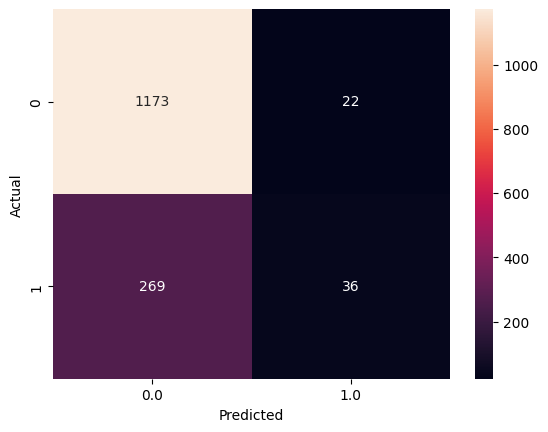

In [6]:
# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predict on the validation set
Y_pred = np.round(model.predict(X_val)) # rounded

# Calculate accuracy
accuracy = accuracy_score(Y_val, Y_pred)
print(f"Accuracy of the model: {accuracy:.2f}")

# Calculate confusion matrix
confusion_matrix = pd.crosstab(Y_val, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()

In [7]:
#See if we can improve the model because there may be features that are not relevant for the classification

X_sm = sm.add_constant(X_train)
smodel = sm.OLS(Y_train, X_sm).fit()
print(smodel.summary())

                            OLS Regression Results                            
Dep. Variable:                 Exited   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     111.1
Date:                Tue, 04 Feb 2025   Prob (F-statistic):          7.17e-235
Time:                        12:10:26   Log-Likelihood:                -3002.3
No. Observations:                7000   AIC:                             6029.
Df Residuals:                    6988   BIC:                             6111.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0697      0.03

In [8]:
#Dropping Tenure, NumOfProducts, HasCrCard and EstimatedSalary because the coefficients are not statistically significant from 0

#Split the data between Training set, Validation set and Testing set.

Y = loan_data['Exited']
X = loan_data.drop(['Exited', 'Tenure', 'NumOfProducts','HasCrCard' , 'EstimatedSalary'], axis = 1)

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=5)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predict on the validation set
Y_pred = np.round(model.predict(X_val)) # rounded

In [9]:
X.head()

,CreditScore,Gender,Age,Balance,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain
0,619,1,42,0.00,1,1.0,0.0,0.0
1,608,1,41,83807.86,1,0.0,0.0,1.0
2,502,1,42,159660.80,0,1.0,0.0,0.0
3,699,1,39,0.00,0,1.0,0.0,0.0
4,850,1,43,125510.82,1,0.0,0.0,1.0


Accuracy of the model: 0.80


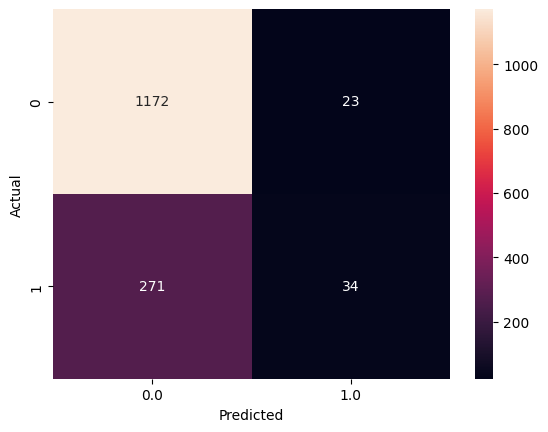

In [10]:
# Calculate accuracy
accuracy = accuracy_score(Y_val, Y_pred)
print(f"Accuracy of the model: {accuracy:.2f}")

# Calculate confusion matrix
confusion_matrix = pd.crosstab(Y_val, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()

In [11]:
# Compute coefficients
np.set_printoptions(suppress=True)
coef = model.coef_
intercept = model.intercept_
print(coef)
print(intercept)

[-0.00011816  0.07258121  0.01112416  0.0000004  -0.1393453  -0.03709787
  0.07660857 -0.0395107 ]
-0.13537926640215378


Accuracy of the model: 0.80


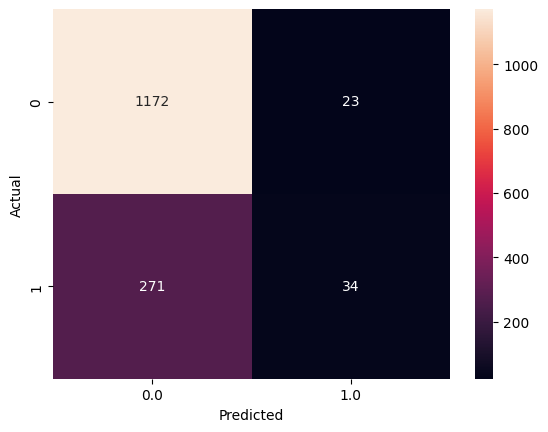

[-0.00011836  0.07261186  0.01112322  0.0000004  -0.13938401  0.11451368]
-0.17309688446999047


In [12]:
#Dropping France and Spain Geographies

Y = loan_data['Exited']
X = loan_data.drop(['Exited', 'Tenure', 'NumOfProducts','HasCrCard' , 'EstimatedSalary', 'Geography_France', 'Geography_Spain'], axis = 1)

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=5)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predict on the validation set
Y_pred = np.round(model.predict(X_val)) # rounded

# Calculate accuracy
accuracy = accuracy_score(Y_val, Y_pred)
print(f"Accuracy of the model: {accuracy:.2f}")

# Calculate confusion matrix
confusion_matrix = pd.crosstab(Y_val, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()

# Compute coefficients
np.set_printoptions(suppress=True)
coef = model.coef_
intercept = model.intercept_
print(coef)
print(intercept)

In [13]:
#predicting a customer

point1_pred = model.predict([[500, 1, 50, 100000, 1, 0]])
print(point1_pred)
point2_pred = model.predict([[500, 1, 50, 100000, 0, 1]])
print(point2_pred)

[0.29714546]
[0.55104315]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [14]:
# Fit the linear regression with the training + validation set
X_train_val = pd.concat((X_train, X_val))
Y_train_val = pd.concat((Y_train, Y_val))

model = LinearRegression()
model.fit(X_train_val, Y_train_val)

# Predict on the testing set
Y_pred = np.round(model.predict(X_test)) # rounded

### 4. Model Evaluation

After choosing the model, I will fit it with the union of the training and validation sets.
Then I will evaluate the testing set.
The evaluation metrics are in the table below.

| Class | Precision | Recall |
| --- | --- | --- |
| 0 | 0.81 | 0.98 |
| 1 | 0.59 | 0.13 |
| Macro avg | 0.70 | 0.55 |
| Weighted avg | 0.77 | 0.80|
| Accuracy 0.80 |

- **Overall performance**   
The accuracy is pretty good at 80%, that means that we didn't overfit or underfit the data and the model performs well in unseen data, at the same level as our validation set.   
The macro avg of recall is low at 55%, and that's due to class imbalance. The recall is very good (98%) for customers that stay in the bank and very low for customers that churn (13%).

- `Class 0. Customers that don't leave the bank`  
The precision is not great at 81% if we consider that customers that don't leave the bank account for 79.6% of the customers, but at least the recall is pretty good at 98%. 

- `Class 1. Customers that churn`   
The recall for Churn customers is better than in the validation set, from 11% to 13%. That's very positive as it means that we're able to identify more customers that will exit the bank. The precision of 59% is the same we had in our validation set.

- **Evaluation**   
The model is effective at classifying customers that will stay in the bank with a very high recall. But due to the poor recall of identifying churn customers, I conclude that Linear Regression does not perform very well in this case as a classifier.   
Even though the model has a low recall at identifying customers that will churn, a 13% still is a good number for the bank trying to retain these customers through some marketing campaigns or other initiatives, considering that the accuracy is acceptable at 59%.   
Due to this limited performance, I would recommend to try other models for classification to improve these performance metrics.
I will a create a Logistic Regression model.

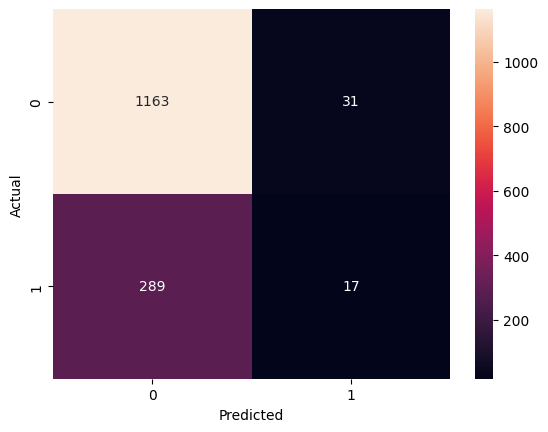

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1194
           1       0.35      0.06      0.10       306

    accuracy                           0.79      1500
   macro avg       0.58      0.51      0.49      1500
weighted avg       0.71      0.79      0.72      1500

Accuracy of the model: 0.78


In [15]:
# Create and fit the logistic regression model
model = LogisticRegression(max_iter = 400)
model.fit(X_train_val, Y_train_val)

# Predict on the testing set
Y_pred = np.round(model.predict(X_test)) # rounded

# Calculate confusion matrix
confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()

# Calculate Classification Report
acc = classification_report(Y_test, Y_pred)
print(acc)

# Calculate accuracy
accuracy = accuracy_score(Y_val, Y_pred)
print(f"Accuracy of the model: {accuracy:.2f}")

### 6. Challenges

- **Feature selection and feature engineering**   
Trying to find the balance between interpretability and model performance has been a challenge. But removing unnecessary features is usually a good option. I have removed them based on their significance after running an OLS model, and also by testing the accuracy after removing certain features. Not all the trials I did are present in the code. Simplifying also the Geography (country) into just one class was a good solution to improve interpretability without compromising performance metrics.
I would have liked to experiment more through feature engineering, like creating balance brackets or indicators for zero balances, but due to time constraints I could not deliver that.